In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric.transforms as T
import tqdm
import random
import matplotlib.pyplot as plt
import networkx as nx
import time

from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.data import DataLoader as GraphDataLoader
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.utils import to_networkx
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch_geometric.data import Batch


In [2]:
# Step 2: Define the GNN model architecture
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads=4)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv3 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.conv4 = GATConv(hidden_channels * 4, hidden_channels, heads=4)
        self.fc1 = Linear(hidden_channels * 4, 128)
        self.fc2 = Linear(128, 64)
        self.fc3 = Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = global_mean_pool(x, batch)
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        return torch.log_softmax(x, dim=-1)
    
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 128 * 14 * 14)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.log_softmax(x, dim=-1)

In [3]:
def train_and_eval(model, train_loader, val_loader, epochs, optimizer, criterion, device):
    model.to(device)
    for epoch in range(epochs):    
        model.train()
        total_loss = 0
        train_iterator = tqdm.tqdm(train_loader, desc=f'Epoch {epoch + 1}, Train Loss: ', leave=False)
        for data in train_iterator:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * data.num_graphs
            train_iterator.set_postfix({'loss': total_loss / len(train_loader.dataset)})
        
        model.eval()
        total_correct = 0
        total_loss = 0
        val_iterator = tqdm.tqdm(val_loader, desc=f'Epoch {epoch + 1}, Val Loss: ', leave=False)
        with torch.no_grad():
            for data in val_iterator:
                data = data.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct = pred.eq(data.y).sum().item()
                total_correct += correct
                loss = criterion(output, data.y)
                total_loss += loss.item() * data.num_graphs
                val_iterator.set_postfix({'loss': total_loss / len(val_loader.dataset), 'accuracy': total_correct / len(val_loader.dataset)})
        
        print(f'Epoch {epoch + 1}, Train Loss: {total_loss / len(train_loader.dataset):.4f}, Val Loss: {total_loss / len(val_loader.dataset):.4f}, Val Accuracy: {total_correct / len(val_loader.dataset):.4f}')

    return

def hyperparameter_tuning(train_loader, test_loader, num_features, num_classes, device):
    search_space = {
        'hidden_channels': [32, 64, 128],
        'lr': [0.001, 0.01, 0.1]
    }

    best_accuracy = 0
    best_hyperparams = None

    for _ in range(2):  
        hyperparams = {
            'hidden_channels': random.choice(search_space['hidden_channels']),
            'lr': random.choice(search_space['lr'])
        }

        model = GNNModel(num_features=num_features,
                         hidden_channels=hyperparams['hidden_channels'],
                         num_classes=num_classes).to(device)

        optimizer = optim.Adam(model.parameters(), lr=hyperparams['lr'])
        
        criterion = nn.NLLLoss()
        
        for epoch in range(15):
            model.train()
            total_loss = 0
            train_iterator = tqdm.tqdm(train_loader, desc=f'Epoch {epoch + 1}/{15}, Loss: ', leave=False)
            for data in train_iterator:
                data = data.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, data.y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * data.num_graphs
                train_iterator.set_postfix({'loss': total_loss / len(train_loader.dataset)})

        model.eval()
        total_correct = 0
        total_loss = 0
        with torch.no_grad():
            for data in test_loader:
                data = data.to(device)
                output = model(data)
                pred = output.argmax(dim=1)
                correct = pred.eq(data.y).sum().item()
                total_correct += correct
                loss = criterion(output, data.y)
                total_loss += loss.item() * data.num_graphs
        
        accuracy = total_correct / len(test_loader.dataset)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams = hyperparams
        
    return best_hyperparams, best_accuracy

def visualize_graph(image, title=None):
    graph = to_networkx(image, to_undirected=True)

    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=False, node_size=10)
    plt.title(title)
    plt.show()

In [4]:
transform = T.Cartesian(cat=False)
train_dataset = MNISTSuperpixels(root='./data', train=True, transform=transform)
test_dataset = MNISTSuperpixels(root='./data', train=False, transform=transform)

train_loader = GraphDataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = GraphDataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
best_hyperparams, best_accuracy = hyperparameter_tuning(train_loader, test_loader, train_dataset.num_features, 10, device)
print(f'Best hyperparameters: {best_hyperparams}, best accuracy: {best_accuracy}')

Best hyperparameters: {'hidden_channels': 64, 'lr': 0.1}, best accuracy: 0.101


In [6]:
model = GNNModel(num_features=train_dataset.num_features, hidden_channels=best_hyperparams['hidden_channels'], num_classes=10)
optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
criterion = nn.NLLLoss()

train_and_eval(model, train_loader, test_loader, 25, optimizer, criterion, device)

Epoch 1, Train Loss: 0.3848, Val Loss: 2.3089, Val Accuracy: 0.1028


Epoch 2, Train Loss: 0.3846, Val Loss: 2.3074, Val Accuracy: 0.1135


Epoch 3, Train Loss: 0.3850, Val Loss: 2.3098, Val Accuracy: 0.0958


Epoch 4, Train Loss: 0.3855, Val Loss: 2.3132, Val Accuracy: 0.0982


Epoch 5, Train Loss: 0.3850, Val Loss: 2.3099, Val Accuracy: 0.1135


Epoch 6, Train Loss: 0.3860, Val Loss: 2.3159, Val Accuracy: 0.0980


Epoch 7, Train Loss: 0.3844, Val Loss: 2.3062, Val Accuracy: 0.0958


Epoch 8, Train Loss: 0.3854, Val Loss: 2.3122, Val Accuracy: 0.1009


Epoch 9, Train Loss: 0.3863, Val Loss: 2.3178, Val Accuracy: 0.0982


Epoch 10, Train Loss: 0.3846, Val Loss: 2.3074, Val Accuracy: 0.1135


Epoch 11, Train Loss: 0.3860, Val Loss: 2.3162, Val Accuracy: 0.0974


Epoch 12, Train Loss: 0.3848, Val Loss: 2.3089, Val Accuracy: 0.0982


Epoch 13, Train Loss: 0.3850, Val Loss: 2.3098, Val Accuracy: 0.0982


Epoch 14, Train Loss: 0.3856, Val Loss: 2.3138, Val Accuracy: 0.1028


Epoch 15, Train Loss: 0.3856, Val Loss: 2.3138, Val Accuracy: 0.1135


Epoch 16, Train Loss: 0.3856, Val Loss: 2.3133, Val Accuracy: 0.1009


Epoch 17, Train Loss: 0.3848, Val Loss: 2.3089, Val Accuracy: 0.1009


Epoch 18, Train Loss: 0.3853, Val Loss: 2.3120, Val Accuracy: 0.1135


Epoch 19, Train Loss: 0.3851, Val Loss: 2.3103, Val Accuracy: 0.0974


Epoch 20, Train Loss: 0.3845, Val Loss: 2.3068, Val Accuracy: 0.1010


Epoch 21, Train Loss: 0.3848, Val Loss: 2.3087, Val Accuracy: 0.1010


Epoch 22, Train Loss: 0.3850, Val Loss: 2.3100, Val Accuracy: 0.1135


Epoch 23, Train Loss: 0.3855, Val Loss: 2.3129, Val Accuracy: 0.1135


Epoch 24, Train Loss: 0.3848, Val Loss: 2.3090, Val Accuracy: 0.1135


Epoch 25, Train Loss: 0.3849, Val Loss: 2.3095, Val Accuracy: 0.0974


c:\Users\asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


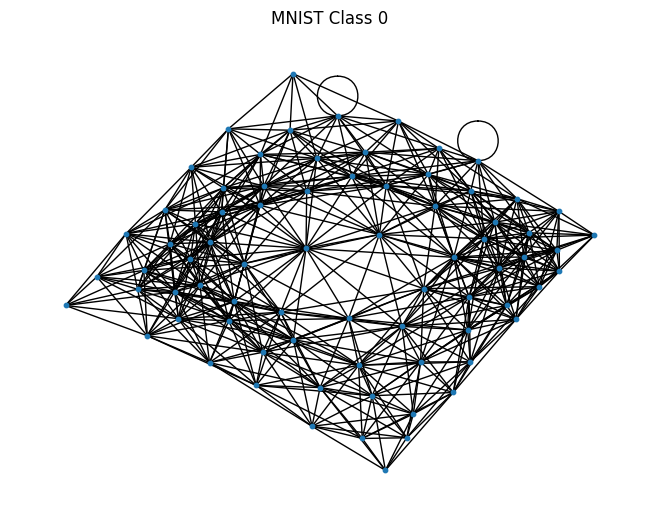

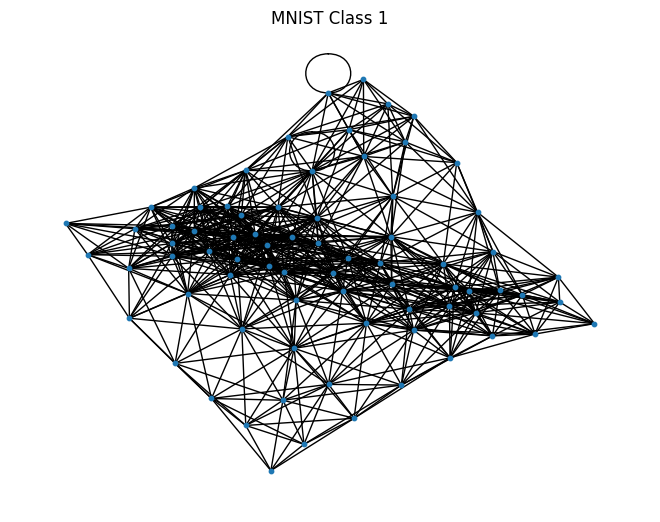

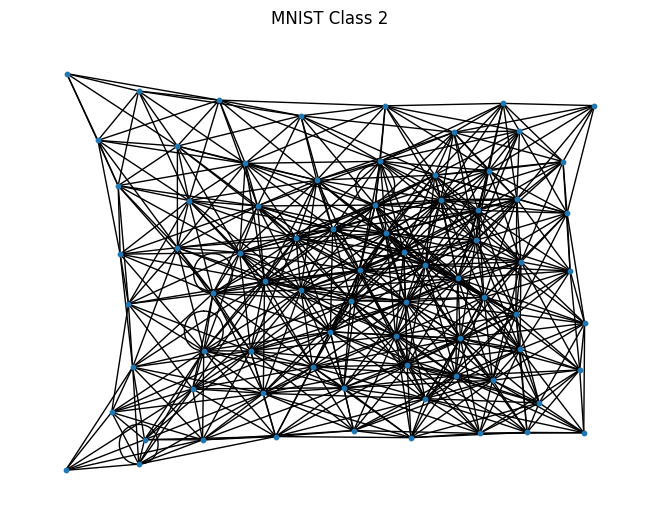

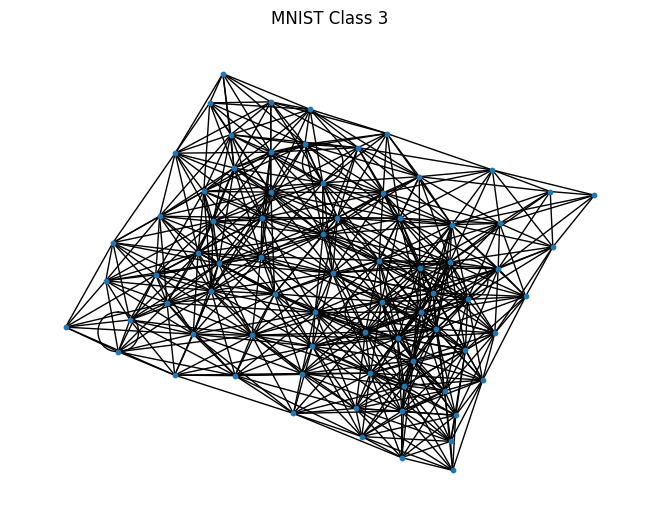

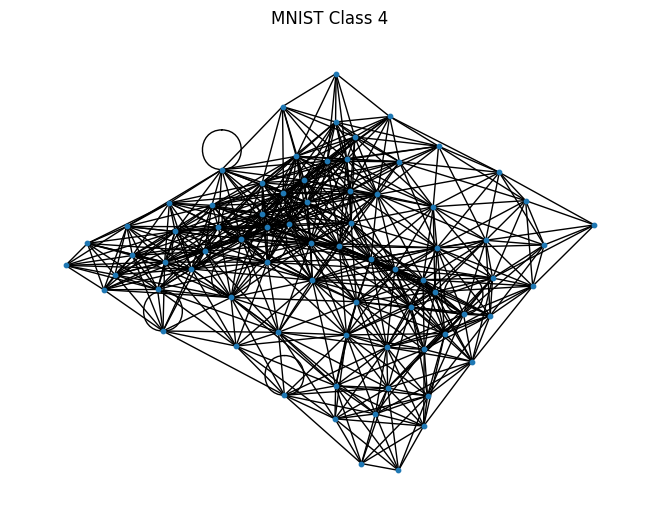

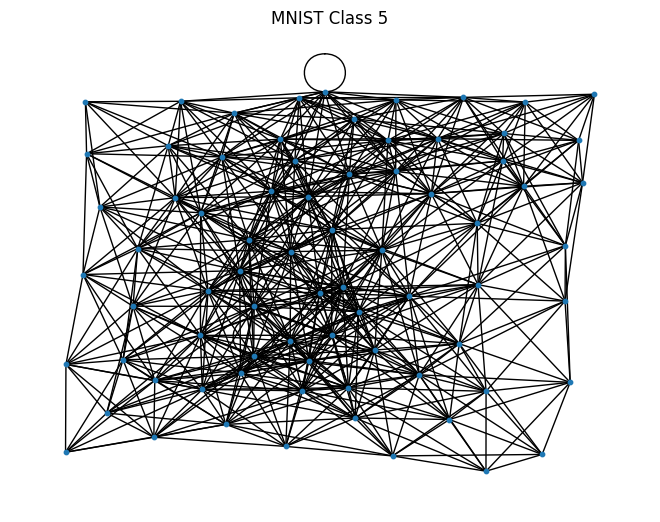

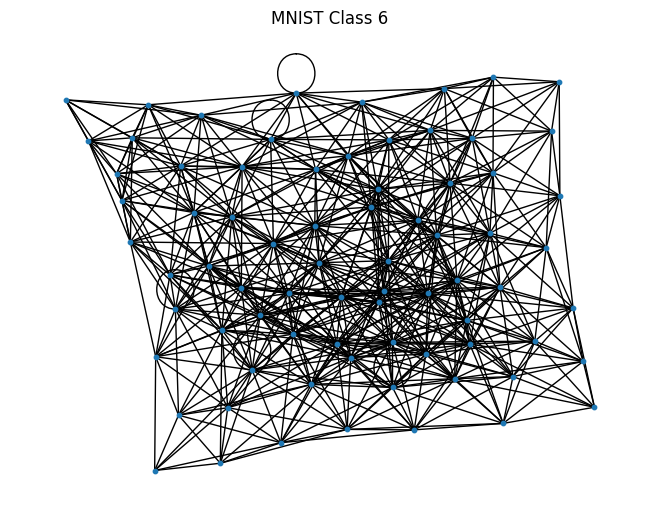

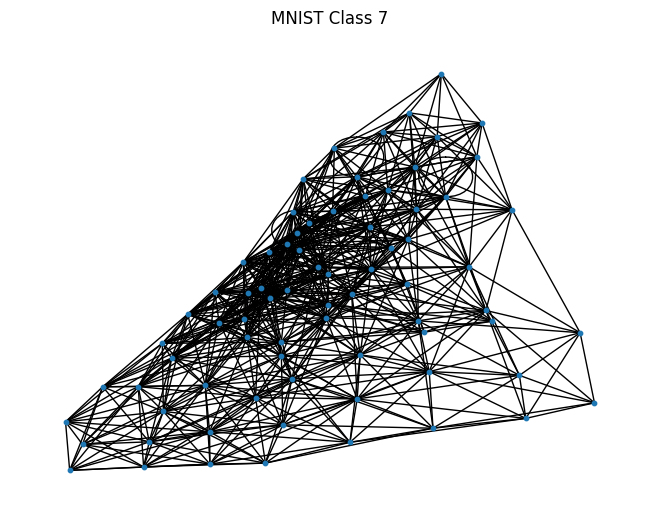

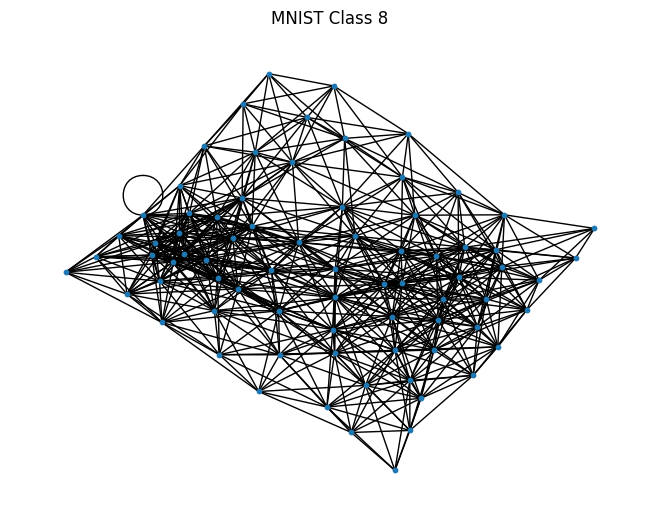

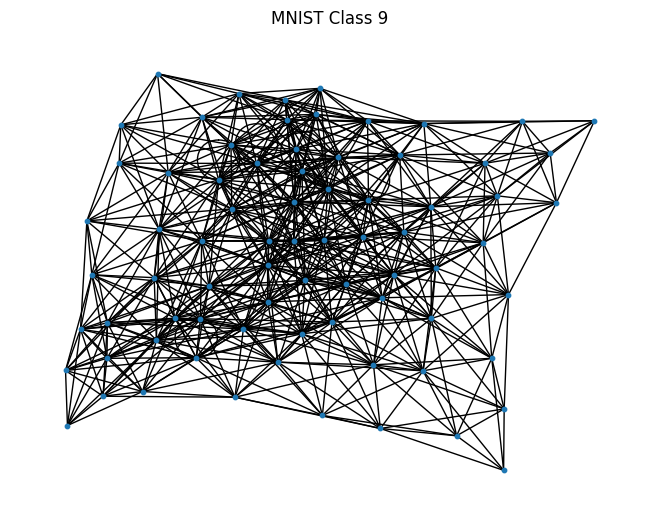

In [7]:
num_classes = 10
for i in range(num_classes):
    example_idx = next(idx for idx, label in enumerate(train_dataset.data.y) if label == i)
    example_image = train_dataset[example_idx]
    
    visualize_graph(example_image, title=f'MNIST Class {i}')

In [8]:
# Load MNIST dataset for CNN
train_dataset_cnn = MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset_cnn = MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_loader_cnn = DataLoader(train_dataset_cnn, batch_size=64, shuffle=True)
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)


In [9]:
cnn_model = CNNModel().to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

start_time_cnn = time.time()
for epoch in range(5):
    cnn_model.train()
    running_loss = 0.0
    total_samples = 0
    correct_samples = 0
    for i, data in enumerate(train_loader_cnn, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_samples += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_samples / total_samples
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
end_time_cnn = time.time()

# Evaluation on test set
cnn_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader_cnn:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_cnn = correct / total
print(f"Accuracy of the CNN on the test set: {accuracy_cnn:.4f}")
print(f"Training time for the CNN: {end_time_cnn - start_time_cnn:.2f} seconds")

Epoch 1, Loss: 0.1590, Accuracy: 0.9509
Epoch 2, Loss: 0.0449, Accuracy: 0.9862
Epoch 3, Loss: 0.0291, Accuracy: 0.9909
Epoch 4, Loss: 0.0204, Accuracy: 0.9936
Epoch 5, Loss: 0.0175, Accuracy: 0.9946
Accuracy of the CNN on the test set: 0.9875
Training time for the CNN: 90.99 seconds
